In [155]:
from PIL import Image
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import os

In [156]:
model = YOLO("yolov8s.pt") # COCO128 classes https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml
# model = YOLO("yolov8n-seg.pt")

In [157]:
def detection(frames: np.array, should_save: bool = False) -> dict:
    results = model(frames, save=should_save)
    detected = {}

    for frame in range(len(results)):
        # print(frame, results[frame].boxes.numpy(), results[frame].boxes.cls)
        boxes = results[frame].boxes
        detected[frame] = []
        for box in boxes:
            box = box.numpy()
            # print(box, box.cls, box.conf)
            if int(box.cls[0]) == 0 and box.conf[0]> 0.7:
                detected[frame].append({
                    "xyxy": box.xyxy,
                    "xywh": box.xywh,
                    "conf": box.conf[0],
                    "center": box.xywh[0][0:2]
                })
        # print('\n')
    return detected

In [158]:
path = "./runs/detect/predict30/og/image%d.jpg"
frames = [Image.open(path % 0), Image.open(path % 1), Image.open(path % 2)]

def distance(point1: np.array, point2: np.array) -> float:
    return np.linalg.norm(point1 - point2)

def is_closer_enough(dist: float, epsilon: float = 20) -> bool:
    return dist <= epsilon

def mean_bbox(frames: dict) -> dict:
    same_bb = []
    for bbox0 in frames[0]:
        same_bb.append([])
        same_bb[-1].append(bbox0)
        # print(same_bbox)
        # print("0: ", bbox0["center"])

        for bbox1 in frames[1]:
            # print("\t1: ", bbox1["center"], "DIST: ", distance(bbox0["center"], bbox1["center"]))
            if is_closer_enough(distance(bbox0["center"], bbox1["center"])): # bbox0 <-> bbox1
                same_bb[-1].append(bbox1)
                # print("FOUND IT \t1: ", bbox1["center"])

        for bbox2 in frames[2]:
            # print("\t2: ", bbox2["center"], "DIST: ", distance(same_bbox[-1][-1]["center"], bbox2["center"]))
            if is_closer_enough(distance(same_bb[-1][-1]["center"], bbox2["center"])): # (bbox1 or bbox0) <-> bbox2
                same_bb[-1].append(bbox2)
                # print("FOUND IT \t2: ", bbox2["center"])

    # return same_bb
    # print(same_bb)
    mean_bb = []
    for bboxes in same_bb:
        bbs = {
            "xyxy": np.mean(np.array([frame["xyxy"] for frame in bboxes]), axis=0),
            "xywh": np.mean(np.array([frame["xywh"] for frame in bboxes]), axis=0),
            "conf": np.mean(np.array([frame["conf"] for frame in bboxes])),
            "center": np.mean(np.array([frame["center"] for frame in bboxes]), axis=0),
        }
        # print([frame["xyxy"] for frame in bboxes])
        # mean_bb.append(np.mean(np.array([frame["xyxy"] for frame in bboxes]), axis=0))
        mean_bb.append(bbs)

    return mean_bb

    # for frame_nr, frame in frames.items():
    #     print(frame_nr)
    #     for bbox in frame:
    #         print(bbox)

In [139]:
detected = detection(frames)
# detected


0: 384x640 4 persons, 1 motorcycle, 1 truck, 2 chairs, 2 dining tables, 2 tvs, 1: 384x640 4 persons, 1 motorcycle, 1 truck, 1 suitcase, 2 chairs, 2 dining tables, 3 tvs, 2: 384x640 4 persons, 1 motorcycle, 1 truck, 2 chairs, 2 dining tables, 3 tvs, 970.3ms
Speed: 2.1ms pre-process, 323.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


In [146]:
mean_bboxes = mean_bbox(detected)

4

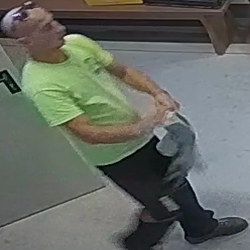

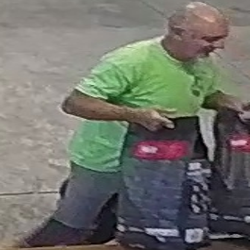

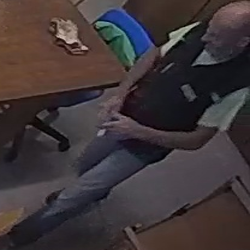

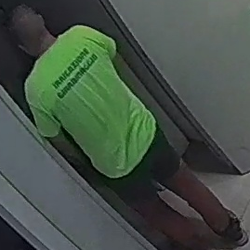

In [153]:
path = "./runs/detect/predict30/og/image%d.jpg"
frames = [Image.open(path % 0), Image.open(path % 1), Image.open(path % 2)]

for meanbb in mean_bboxes:
    bbox = meanbb["xyxy"][0].astype(int).tolist()
    # bboxwh = meanbb["xywh"][0].astype(int).tolist()
    cropped = frames[0].crop(bbox)
    resized = cropped.resize((250, 250))
    display(resized)

In [ ]:
bbs = detection([image, image, image], True)
#
# print(bbs)

result = Image.open('./runs/detect/predict/image0.jpg')
display(result)

for bb in bbs[0]:
    bbox = bb["xyxy"][0].astype(int).tolist()
    bboxwh = bb["xywh"][0].astype(int).tolist()
    cropped = image.crop(bbox)
    resized = cropped.resize((250, 250))
    display(resized)

bbs

# for _, bb in bbs[0].items():
#     for bbox in bb:
#         bbox = bbox.xyxy[0].astype(int).tolist()
#
#         cropped = image.crop(bbox)
#         resized = cropped.resize((250, 250))
#         display(resized)

In [159]:
file_path = 'test.mp4'
delay = 1
window_name = 'frame'

cap = cv2.VideoCapture(file_path)
# cap = cv2.VideoCapture(0)

if not cap.isOpened():
    sys.exit()

count = 3
frames = []
round = 0
# while round < 20:
while True:
    ret, frame = cap.read()
    frames.append(frame)
    count -= 1
    # print(count, frames)

    if count == 0:
        # print(frames)
        os.makedirs("./runs/detect/predict/og/")
        for index in range(len(frames)):
            cv2.imwrite("./runs/detect/predict/og/image%d.jpg" % index, frames[index])

        bbs = detection(frames)
        os.rename("./runs/detect/predict", "./runs/detect/predict%d" % round)

        count = 3
        frames = []
        round += 1

    if ret:
        # cv2.imshow(window_name, frame)
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
    else:
        os.makedirs("./runs/detect/predict/og/")
        for index in range(len(frames)):
            cv2.imwrite("./runs/detect/predict/og/image%d.jpg" % index, frames[index])
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        break

cap.release()
cv2.destroyWindow(window_name)

Ultralytics YOLOv8.0.25 🚀 Python-3.10.9 torch-1.13.1 CPU
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

0: 384x640 3 persons, 1 motorcycle, 2 trucks, 2 chairs, 1 potted plant, 2 dining tables, 3 tvs, 1: 384x640 3 persons, 1 motorcycle, 2 trucks, 1 suitcase, 2 chairs, 1 potted plant, 2 dining tables, 3 tvs, 2: 384x640 3 persons, 1 motorcycle, 2 trucks, 2 chairs, 1 potted plant, 3 dining tables, 3 tvs, 1068.4ms
Speed: 3.4ms pre-process, 356.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 motorcycle, 2 trucks, 1 suitcase, 2 chairs, 1 potted plant, 3 dining tables, 4 tvs, 1: 384x640 3 persons, 1 motorcycle, 1 truck, 2 chairs, 3 dining tables, 4 tvs, 2: 384x640 3 persons, 1 motorcycle, 1 truck, 1 suitcase, 2 chairs, 3 dining tables, 6 tvs, 1022.3ms
Speed: 1.9ms pre-process, 340.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 motorcycle, 1 truck, 1 suitcase, 2 chai

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [23]:
results = model([image], save=True)
# results = results
print(results)

boxes, masks, probs = ([], [], [])
for result in results:
    # print(result)
    boxes = result.boxes.numpy()
    masks = result.masks
    probs = result.probs

# print("Boxes")
print(boxes)
# print("Masks")
# print(masks)
# print("Probs")
# print(probs)

Ultralytics YOLOv8.0.25 🚀 Python-3.10.9 torch-1.13.1 CPU
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

0: 256x640 6 persons, 105.2ms
Speed: 0.9ms pre-process, 105.2ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
type: <class 'torch.Tensor'>
shape: torch.Size([6, 6])
dtype: torch.float32
 + tensor([[9.90000e+01, 5.00000e+00, 3.18000e+02, 3.83000e+02, 9.19241e-01, 0.00000e+00],
        [3.07000e+02, 6.50000e+01, 4.40000e+02, 3.85000e+02, 8.73961e-01, 0.00000e+00],
        [7.40000e+02, 5.40000e+01, 9.46000e+02, 3.87000e+02, 8.54227e-01, 0.00000e+00],
        [4.07000e+02, 5.40000e+01, 6.00000e+02, 3.86000e+02, 8.24071e-01, 0.00000e+00],
        [6.62000e+02, 2.90000e+01, 7.96000e+02, 3.83000e+02, 7.77542e-01, 0.00000e+00],
        [5.43000e+02, 6.00000e+01, 6.52000e+02, 3.82000e+02, 7.09505e-01, 0.00000e+00]])]
[[         99           5         318         383     0.91924           0]
 [        307          65         440         385     0.87396           0]
 [        740          54         946         387     0.85423           0]
 [        407          54         600         386     0.82407           0]
 [        662      

In [24]:
for bbox in boxes:
    bbox = bbox.xyxy[0].astype(int).tolist()

    cropped = image.crop(bbox)
    resized = cropped.resize((250, 250))
    # display(resized)

In [21]:
# Image.open('runs/detect/predict/image0.jpg')
# Image.open('runs/segment/predict/image0.jpg')